# Imitation Learning for Mathematical Reasoning: GSM8K with Qwen2.5-1.5B

This notebook demonstrates **imitation learning** (behavior cloning) for improving mathematical reasoning in small language models. We fine-tune Qwen2.5-1.5B (1.5 billion parameters) on the GSM8K dataset using synthetic chain-of-thought reasoning generated by three powerful teacher models:

- **GPT-4o-mini** (OpenAI)
- **DeepSeek-chat** (DeepSeek)
- **Gemini Flash** (Google)

### Key Results

| Approach | Accuracy | vs. Base Model |
|----------|----------|----------------|
| Base Model (no tuning) | 60% | - |
| Fine-tuned on GSM8K | 63% | +3% |
| **GPT-4o-mini imitation** | **67%** | **+7%** |
| DeepSeek imitation | 66% | +6% |
| Gemini imitation | 63% | +3% |


## 1. Setup

In [ ]:
%pip install trl

In [ ]:
%pip install bitsandbytes
%pip install anthropic

In [3]:
import os
import json
import re
import torch
import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import Dict, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, BitsAndBytesConfig, pipeline
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
from datasets import load_dataset, Dataset
import random
from openai import OpenAI
from google.colab import userdata
import google.generativeai as genai
from anthropic import Anthropic
from peft import PeftModel

In [33]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Output directory for saving models
OUTPUT_DIR = "./models"

STUDENT_MODEL = "Qwen/Qwen2.5-1.5B-Instruct"
TEACHER_GPT = "gpt-4o-mini"
TEACHER_DEEPSEEK = "deepseek-chat"
TEACHER_GEMINI = "gemini-flash-latest"

# test-train size; use subsets for faster training
TRAIN_SIZE = 100
TEST_SIZE = 100
MAX_NEW_TOKENS = 1024
TEACHER_TEMPERATURE = 0.3
TEACHER_MAX_TOKENS = 1024

NUM_EPOCHS = 3

In [5]:
# Load GSM8K dataset
dataset = load_dataset("openai/gsm8k", "main")

dataset

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1319
    })
})

In [6]:
# Inspect a sample
sample = dataset['train'][random.randint(0, len(dataset['train']))]
print(f"Question: {sample['question']}")
print(f"Answer: {sample['answer']}")

Question: For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive?
Answer: There are 144/12 = <<144/12=12>>12 sets of 12 cans that the family collected.
So, the family would receive $0.50 x 12 = $<<0.50*12=6>>6 for the cans.
There are 20/5 = <<20/5=4>>4 sets of 5 kilograms of newspapers that the family collected.
So, the family would receive $1.50 x 4 = $<<1.50*4=6>>6 for the newspapers.
Therefore, the family would receive a total of $6 + $6 = $<<6+6=12>>12.
#### 12


In [34]:
train_data = dataset['train'].shuffle(seed=42).select(range(TRAIN_SIZE))
test_data = dataset['test'].shuffle(seed=42).select(range(TEST_SIZE))

## 2. Model Loading and Lora Configuration

Instead of updating all 1.5B parameters, LoRA adds small trainable matrices to specific layers.
The model weights are compressed from 32-bit to 4-bit.

In [8]:
# Configure 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [9]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(STUDENT_MODEL)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"Tokenizer loaded. Vocab size: {len(tokenizer)}")
tokenizer.eos_token

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Tokenizer loaded. Vocab size: 151665


'<|im_end|>'

In [10]:
# LoRA configuration
lora_config = LoraConfig(
    r=32,
    lora_alpha=64,  # Scaling factor
    # model layers to apply LoRA
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

## 3. Modules for training

In [11]:
def load_model_for_training(model_name: str = STUDENT_MODEL, bnb_config=None):
    """
    Load a model for training with quantization and proper configuration.
    """
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        dtype=torch.bfloat16
    )

    model.lm_head = model.lm_head.to(torch.float32)
    model.config.use_cache = False

    return model

def load_model_for_inference(adapter_path: str, model_name: str = STUDENT_MODEL):
    """
    Load a model for inference, merge with adapter weights, and set to eval mode.
    """
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        dtype=torch.bfloat16,
    )

    model = PeftModel.from_pretrained(model, adapter_path)
    model = model.merge_and_unload()
    model.eval()

    return model

def train_and_save_model(train_dataset, output_name: str, num_epochs: int = NUM_EPOCHS):
    """
    Train a model with the given dataset and save adapter weights.
    Returns the path to the saved adapter.
    """
    # Load model for training
    model = load_model_for_training(STUDENT_MODEL, bnb_config)

    # Get training arguments
    output_dir = os.path.join(OUTPUT_DIR, output_name)
    training_args = get_training_args(output_dir=output_dir, num_epochs=num_epochs)

    # Initialize trainer
    trainer = SFTTrainer(
        model=model,
        train_dataset=train_dataset,
        peft_config=lora_config,
        args=training_args
    )

    # Train
    trainer.train()

    # Save adapter weights
    adapter_path = os.path.join(output_dir, "adapter")
    trainer.model.save_pretrained(adapter_path)

    # Clear GPU memory
    del model, trainer
    torch.cuda.empty_cache()

    return adapter_path

def evaluate_finetuned_model(adapter_path: str, test_dataset, model_name: str):
    """
    Load a fine-tuned model with adapters, evaluate it, and clean up.
    Returns evaluation results.
    """
    # Load model with adapters
    model = load_model_for_inference(adapter_path, STUDENT_MODEL)

    # Evaluate
    results = evaluate_model(model, tokenizer, test_dataset, model_name)

    # Clear GPU memory
    del model
    torch.cuda.empty_cache()

    return results

In [12]:
def generate_synthetic_dataset(train_dataset, teacher: str):
    """
    Generate a synthetic dataset using a teacher model.
    """
    synthetic_train = train_dataset.map(
        format_synthetic_cot,
        remove_columns=train_dataset.column_names,
        desc=f"Generating synthetic reasoning - {teacher}",
        fn_kwargs={"teacher": teacher}
    )
    return synthetic_train

In [13]:
def get_training_args(output_dir: str, num_epochs: int = NUM_EPOCHS) -> TrainingArguments:
    """
    Create training arguments
    """
    return TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,   # effective batch size 16

        # Optimization
        learning_rate=.1e-5,
        lr_scheduler_type="cosine",
        warmup_ratio=0.1,
        weight_decay=0.01,

        # Memory optimization
        fp16=False,
        bf16=True,  # for better stability
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={"use_reentrant": False},

        # Logging
        logging_steps=20,
        logging_first_step=True,

        # Saving
        save_strategy="epoch",
        save_total_limit=2,

        # Other
        optim="adamw_torch",
        report_to="none",
        seed=42,
    )

In [14]:
def format_gsm8k_direct(example: Dict) -> Dict:
    question = example["question"]
    original_answer = example["answer"]

    messages = [
        {"role": "user", "content": f"Solve this math problem step by step:\n\n{question}"},
        {"role": "assistant", "content": original_answer},
    ]
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False)}

# Build the direct GSM8K training split
gsm8k_train = train_data.map(
    format_gsm8k_direct,
    remove_columns=train_data.column_names,
    desc="Generating direct GSM8K formatted data",
)

Generating direct GSM8K formatted data:   0%|          | 0/100 [00:00<?, ? examples/s]

In [15]:
adapter_path = train_and_save_model(gsm8k_train, "cot_qwen_gsm8k", num_epochs=NUM_EPOCHS)

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Adding EOS to train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss
1,1.461300
20,1.509500


## 4. Modules for evaluation

In [16]:
def model_response(model, tokenizer, question: str, max_new_tokens: int = MAX_NEW_TOKENS) -> str:
    """
    Generate an answer from the model for a given question.
    """
    # Set padding to left for generation
    #tokenizer.padding_side = "left"
    # Format prompt in the style that Qwen uses
    messages = [
        {"role": "user", "content": f"Solve this math problem step by step. Show your reasoning clearly. End with the final numerical answer after '####'.\n\n Problem: {question}"}
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # Greedy decoding for consistency
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Decode only the generated tokens without the input prompt
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return generated_text.strip()

In [ ]:
def extract_numerical_answer(text: str) -> Optional[str]:
    """
    Extract the final numerical answer from model output.
    """

    text = text.replace(tokenizer.eos_token, '').strip()

    # Check for #### format first
    if '####' in text:
        answer = text.split('####')[-1].strip()
        # Extract numbers
        numbers = re.findall(r'-?\d+\.?\d*', answer)
        if numbers:
            return numbers[0]

    # Look for patterns like "the answer is X" or "= X"
    patterns = [
        r'[Tt]he answer is\s*(-?\d+\.?\d*)',
        r'[Aa]nswer:\s*(-?\d+\.?\d*)',
        r'=\s*(-?\d+\.?\d*)\s*$',
        r'(-?\d+\.?\d*)\s*$',  # Last number in text
    ]

    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            return match.group(1)

    # If no pattern matches, try to extract any number
    numbers = re.findall(r'-?\d+\.?\d*', text)
    if numbers:
        return numbers[-1]  # Return last number found

    return None

def normalize_answer(answer: str) -> str:
    """
    Normalize answer for comparison (handle decimals, commas, etc.)
    """
    if answer is None:
        return ""

    # Remove commas and whitespace
    answer = answer.replace(',', '').strip()

    # Convert to float and back to remove trailing zeros
    try:
        num = float(answer)
        # If it's a whole number, return as int
        if num == int(num):
            return str(int(num))
        return str(num)
    except:
        return answer

def evaluate_model(model, tokenizer, test_dataset, model_name: str) -> Dict:
    """
    Evaluate model on a subset of the test set and return accuracy metrics.
    """
    correct = 0
    total = 0
    results = []

    test_subset_size = len(test_dataset)
    test_subset = test_dataset.select(range(test_subset_size))

    # Create progress bar
    pbar = tqdm(test_subset, desc=f"Evaluating {model_name}")

    for example in pbar:
        question = example['question']
        true_answer = normalize_answer(extract_numerical_answer(example['answer']))

        # Generate model response
        response = model_response(model, tokenizer, question, max_new_tokens=MAX_NEW_TOKENS)

        # Extract predicted answer
        pred_answer = extract_numerical_answer(response)
        pred_answer = normalize_answer(pred_answer)

        # Check if correct
        is_correct = (pred_answer == true_answer)
        if is_correct:
            correct += 1
        total += 1

        results.append({
            'question': question,
            'true_answer': true_answer,
            'predicted_answer': pred_answer,
            'correct': is_correct,
            'response': response
        })

        running_acc = (correct / total) * 100
        pbar.set_postfix({'correct': f'{correct}/{total}', 'acc': f'{running_acc:.1f}%'})

    accuracy = correct / total if total > 0 else 0

    print(f"\n{model_name} Results:")
    print(f"  Correct: {correct}/{total}")
    print(f"  Accuracy: {accuracy*100:.2f}%")

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'correct': correct,
        'total': total,
        'results': results
    }

In [35]:
base_model_cot_results = evaluate_finetuned_model(adapter_path, test_data, "Fine-tuned Base Model")

Evaluating Fine-tuned Base Model:   0%|          | 0/100 [00:00<?, ?it/s]


Fine-tuned Base Model Results:
  Correct: 63/100
  Accuracy: 63.00%


In [36]:
print("EVALUATION: Base Qwen2.5-1.5B without fine-tuning")
base_model_eval = load_model_for_training(STUDENT_MODEL, bnb_config)
base_model_eval.lm_head = base_model_eval.lm_head.to(torch.float32)
base_model_results = evaluate_model(base_model_eval, tokenizer, test_data, "Base Model")

# Clear GPU memory
del base_model_eval
torch.cuda.empty_cache()

EVALUATION: Base Qwen2.5-1.5B without fine-tuning


Evaluating Base Model:   0%|          | 0/100 [00:00<?, ?it/s]


Base Model Results:
  Correct: 60/100
  Accuracy: 60.00%


## 5. Generate synthetic datasets

### Teacher Reasoning Style Comparison

Notice the differences in how each teacher explains the same problem:

- **GPT-4o-mini**: Formal, mathematical notation, very structured
- **DeepSeek**: Concise, clean layout, efficient explanations
- **Gemini**: Verbose, uses LaTeX formatting, very detailed sections

These different styles will teach the student model various reasoning approaches!

In [20]:
tokenizer.padding_side = "right"

# API clients for synthetic CoT generation
OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
DEEPSEEK_API_KEY = userdata.get("DEEPSEEK_API_KEY")
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")

openai_client = OpenAI(api_key=OPENAI_API_KEY)
deepseek_client = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com")
genai.configure(api_key=GOOGLE_API_KEY)
gemini_model = genai.GenerativeModel(TEACHER_GEMINI)

In [21]:
def generate_synthetic_cot(question: str, teacher: str = "gpt") -> str:
    #time.sleep(0.5)
    prompt = (
        "Solve this grade school math problem step by step. "
        "Show your reasoning clearly. End with the final numerical answer after '####'.\n\n"
        f"Problem: {question}\n\nSolution:"
    )

    config = {"temperature": TEACHER_TEMPERATURE, "max_tokens": TEACHER_MAX_TOKENS}

    if "gpt" in teacher.lower() or "deepseek" in teacher.lower():
        client = openai_client if teacher == "gpt" else deepseek_client
        model = TEACHER_GPT if teacher == "gpt" else TEACHER_DEEPSEEK
        resp = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            **config
        )
        return resp.choices[0].message.content

    elif "gemini" in teacher.lower():
        return gemini_model.generate_content(prompt).text

    raise ValueError(f"Unknown teacher: {teacher}")

def format_synthetic_cot(example: Dict, teacher: str = "gpt") -> Dict:
    question = example["question"]
    try:
        synthetic_answer = generate_synthetic_cot(question, teacher=teacher)
    except Exception as e:
        print(f"Error generating synthetic CoT: {e}")
        synthetic_answer = example.get("answer", "")

    messages = [
        {"role": "user", "content": f"Solve this math problem step by step:\n\n{question}"},
        {"role": "assistant", "content": synthetic_answer},
    ]
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False)}


In [22]:
gpt_train = generate_synthetic_dataset(train_data, "gpt")

Parameter 'function'=<function format_synthetic_cot at 0x7f0d21416ac0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Generating synthetic reasoning - gpt:   0%|          | 0/100 [00:00<?, ? examples/s]

In [23]:
deepseek_train = generate_synthetic_dataset(train_data, "deepseek")

Generating synthetic reasoning - deepseek:   0%|          | 0/100 [00:00<?, ? examples/s]

In [24]:
gemini_train = generate_synthetic_dataset(train_data, "gemini")

Generating synthetic reasoning - gemini:   0%|          | 0/100 [00:00<?, ? examples/s]

In [25]:
print(f"GPT:\n{gpt_train[0]["text"]}\n Deepseek:\n {deepseek_train[0]["text"]}\n Gemini:\n {gemini_train[0]['text']}")

GPT:
<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Solve this math problem step by step:

Mimi picked up 2 dozen seashells on the beach.  Kyle found twice as many shells as Mimi and put them in his pocket. Leigh grabbed one-third of the shells that Kyle found.  How many seashells did Leigh have?<|im_end|>
<|im_start|>assistant
To solve the problem, we will follow the steps outlined in the problem statement.

1. **Determine how many seashells Mimi picked up:**
   - Mimi picked up 2 dozen seashells.
   - Since 1 dozen equals 12, we calculate:
     \[
     2 \text{ dozen} = 2 \times 12 = 24 \text{ seashells}
     \]

2. **Calculate how many seashells Kyle found:**
   - Kyle found twice as many shells as Mimi.
   - Therefore, we calculate:
     \[
     \text{Kyle's seashells} = 2 \times 24 = 48 \text{ seashells}
     \]

3. **Determine how many seashells Leigh grabbed:**
   - Leigh grabbed one-third of the shells that Kyl

## 6. Training from Teacher Models and Evaluation

### 6.1 Gpt

In [26]:
adapter_path_gpt = train_and_save_model(gpt_train, "qwen_gsm8k-gpt", num_epochs=NUM_EPOCHS)

Adding EOS to train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss
1,0.755100
20,0.734300


In [37]:
gpt_model_results = evaluate_finetuned_model(adapter_path_gpt, test_data, "GPT Fine-tuned Model")

Evaluating GPT Fine-tuned Model:   0%|          | 0/100 [00:00<?, ?it/s]


GPT Fine-tuned Model Results:
  Correct: 67/100
  Accuracy: 67.00%


### 6.2 Deepseek

In [28]:
adapter_path_deepseek = train_and_save_model(deepseek_train, "cot_qwen_gsm8k-deepseek", num_epochs=NUM_EPOCHS)

Adding EOS to train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss
1,1.248900
20,1.275200


In [38]:
deepseek_model_results = evaluate_finetuned_model(adapter_path_deepseek, test_data, "Deepseek Fine-tuned Model")

Evaluating Deepseek Fine-tuned Model:   0%|          | 0/100 [00:00<?, ?it/s]


Deepseek Fine-tuned Model Results:
  Correct: 66/100
  Accuracy: 66.00%


### 6.3. Gemini

In [30]:
adapter_path_gemini = train_and_save_model(gemini_train, "cot_qwen_gsm8k-gemini", num_epochs=NUM_EPOCHS)

Adding EOS to train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss
1,1.070500
20,1.030200


In [39]:
gemini_model_results = evaluate_finetuned_model(adapter_path_gemini, test_data, "Gemini Fine-tuned Model")

Evaluating Gemini Fine-tuned Model:   0%|          | 0/100 [00:00<?, ?it/s]


Gemini Fine-tuned Model Results:
  Correct: 63/100
  Accuracy: 63.00%


# 7. Results

EVALUATION RESULTS SUMMARY

Dataset: GSM8K
Test Size: 100 examples
Training Size: 100 examples
Student Model: Qwen/Qwen2.5-1.5B-Instruct

                    Model Accuracy (%)  Correct  Total
               Base Model       60.00%       60    100
    Fine-tuned Base Model       63.00%       63    100
     GPT Fine-tuned Model       67.00%       67    100
Deepseek Fine-tuned Model       66.00%       66    100
  Gemini Fine-tuned Model       63.00%       63    100



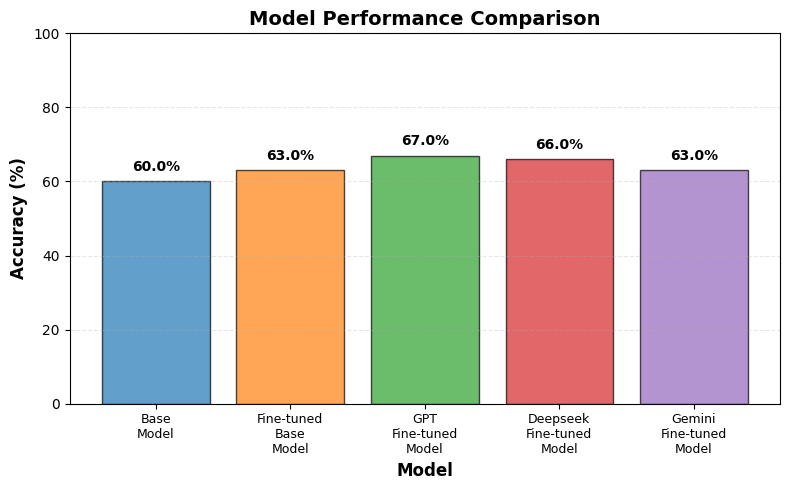


KEY INSIGHTS

Best Performing Model: GPT Fine-tuned Model
  - Accuracy: 67.00%
  - Correct: 67/100

Comparison with Base Model (No Fine-tuning):
  - Fine-tuned Base Model: +3.00% improvement
  - GPT Fine-tuned Model: +7.00% improvement
  - Deepseek Fine-tuned Model: +6.00% improvement
  - Gemini Fine-tuned Model: +3.00% improvement



In [40]:
# Compile all evaluation results
all_results = [
    base_model_results,
    base_model_cot_results,
    gpt_model_results,
    deepseek_model_results,
    gemini_model_results
]

summary_data = []
for result in all_results:
    summary_data.append({
        'Model': result['model_name'],
        'Accuracy (%)': f"{result['accuracy']*100:.2f}%",
        'Correct': result['correct'],
        'Total': result['total']
    })

summary_df = pd.DataFrame(summary_data)

print("="*80)
print("EVALUATION RESULTS SUMMARY")
print("="*80)
print(f"\nDataset: GSM8K")
print(f"Test Size: {TEST_SIZE} examples")
print(f"Training Size: {TRAIN_SIZE} examples")
print(f"Student Model: {STUDENT_MODEL}")
print(f"\n{summary_df.to_string(index=False)}")
print("\n" + "="*80)

# Visualization (single plot)
plt.figure(figsize=(8, 5)) # Create a single figure

model_names = [r['model_name'] for r in all_results]
accuracies = [r['accuracy'] * 100 for r in all_results]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = plt.bar(range(len(model_names)), accuracies, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(range(len(model_names)), [name.replace(' ', '\n') for name in model_names], rotation=0, ha='center', fontsize=9)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{acc:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

best_model = max(all_results, key=lambda x: x['accuracy'])
print(f"\nBest Performing Model: {best_model['model_name']}")
print(f"  - Accuracy: {best_model['accuracy']*100:.2f}%")
print(f"  - Correct: {best_model['correct']}/{best_model['total']}")

# Compare with base model
base_acc = base_model_results['accuracy']
print(f"\nComparison with Base Model (No Fine-tuning):")
for result in all_results[1:]:  # Skip base model itself
    diff = (result['accuracy'] - base_acc) * 100
    sign = "+" if diff >= 0 else ""
    print(f"  - {result['model_name']}: {sign}{diff:.2f}% {'improvement' if diff >= 0 else 'degradation'}")

print("\n" + "="*80)